<a href="https://colab.research.google.com/github/tono000/CS114.K11/blob/master/Fine_tuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import math
import cv2
from sklearn.model_selection import train_test_split

In [2]:
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from keras.applications import VGG16
from keras.applications import imagenet_utils
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import load_img
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from imutils import paths
import numpy as np
import pickle
import random



Using TensorFlow backend.


In [3]:
from google.colab import drive
drive.mount('/mydrive',True)

Mounted at /mydrive


In [4]:
path = '/mydrive/My Drive/hog_R_CNN_dataset'
folder = path
print(folder)

/mydrive/My Drive/hog_R_CNN_dataset


In [0]:
dem=0
data=[0,0]
X = pd.DataFrame(columns=range(224*224))
Y = pd.DataFrame(columns=range(1))
from google.colab.patches import cv2_imshow

for i in range(0,2):
  temp_arr=[]
  temp_label=[]
  branch_folder = folder + "/" + os.listdir(folder)[i]
  for filenames in os.listdir(branch_folder):
          print(dem)
          img=cv2.imread(branch_folder+'/'+filenames)
          print(branch_folder+'/'+filenames)
          imgCrop=img[0:((img.shape[0]-1)//2),]     
          imgCrop=cv2.resize(imgCrop, (224,224))
          arr=imgCrop.flatten()   
          temp_arr.append(arr)
          temp_label.append(1-i)
          dem=dem+1
          
  t=pd.DataFrame(data = temp_arr)
  X=X.append(t,ignore_index=True)
  Y=Y.append(temp_label,ignore_index=True)
          
  


In [0]:
le = LabelEncoder()
labels = le.fit_transform(Y)
labels=pd.DataFrame(data = labels)

In [0]:
list_image = []
from google.colab.patches import cv2_imshow
for i in range(0,2):
  temp_arr=[]
  branch_folder = folder + "/" + os.listdir(folder)[i]
  for imagePath in os.listdir(branch_folder):

      #resize ảnh về 224x224 pixels
      
        image = load_img(branch_folder+"/"+imagePath,color_mode='rgb',target_size=(448,224))
        
        print(imagePath)
        
        image = img_to_array(image)
        image=image[0:224,]
        image = preprocess_input(image)
        cv2_imshow(image)
        #expand_dims thêm chiều cho input image.shape = (1,224,224,3)
        image = np.expand_dims(image, axis = 0)
        list_image.append(image)

      
      
      
      
#thêm vào mảng để có được (n,224,224,3) trong đó n là số lượng ảnh được xử lý
list_image = np.vstack(list_image)

In [0]:
from keras.layers import Input
weights = 'imagenet' #để load pre-trained model trên tập imagenet, (224,224,3) là kích thước ảnh đầu vào
baseModel = VGG16(weights = 'imagenet', include_top=False, input_tensor = Input(shape=(224, 224, 3)))

In [0]:
from keras.layers import Dense, Activation, Flatten
from keras.layers import Dropout
from keras.models import Model

# the base model
headModel = baseModel.output
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(1024, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="softmax")(headModel)
#nối VGG16 và head
modelvgg  = Model(inputs=baseModel.input, outputs=headModel)
modelvgg.summary()

In [0]:
from keras.preprocessing.image import ImageDataGenerator
#horizontal_flip = True lật ngang
aug_train = ImageDataGenerator(
      rescale=1./255,
      rotation_range=20,
      width_shift_range=0.2,
      height_shift_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')
aug_test= ImageDataGenerator(rescale=1./255)

In [0]:
# Chia traing set, test set tỉ lệ 80-20
from keras.utils.np_utils import to_categorical
train_labels = to_categorical(labels)

X_train, X_test, y_train, y_test = train_test_split(list_image, train_labels, test_size=0.2, random_state=42)

In [0]:
#freeze 
from keras import optimizers
for layer in baseModel.layers:
    layer.trainable = False
baseModel.summary()

In [0]:
from keras.optimizers import SGD
import tensorflow as tf

# không train trên các layer ConvNet của VGG16
modelvgg.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-4),
              metrics=['acc'])
H = modelvgg.fit_generator(aug_train.flow(X_train, y_train, batch_size=32), 
                        steps_per_epoch = len(X_train)//32,
                        validation_data = (aug_test.flow(X_test, y_test, batch_size=32)),
                        validation_steps = len(X_test)//32,
                        epochs = 50)

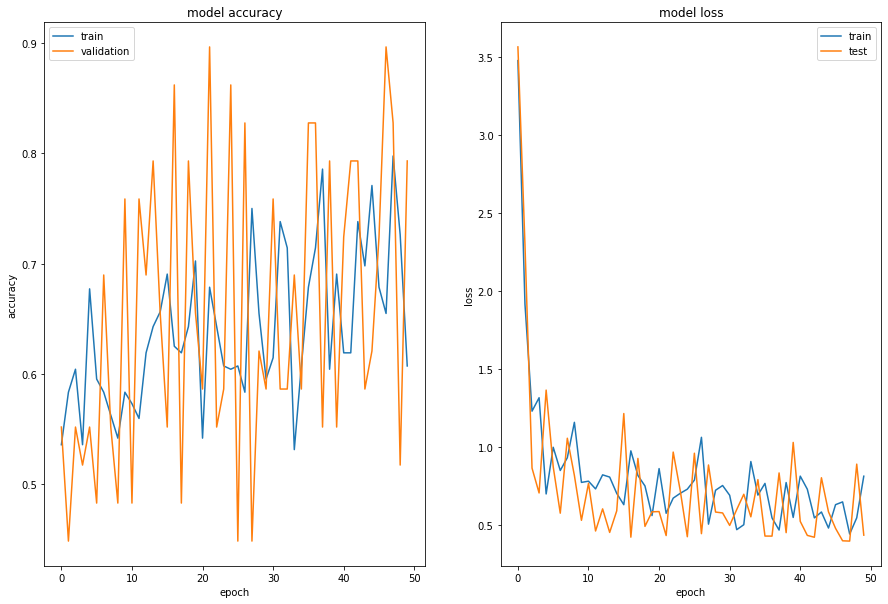

In [14]:
def plot_acc_loss(history):
    fig = plt.figure(figsize=(15,10))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
 
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper right')
    plt.show()
plot_acc_loss(H)

In [0]:
# unfreeze 1 số layer
for layer in baseModel.layers[15:]:
    layer.trainable = True
numOfEpoch = 10
opt = optimizers.SGD(0.001)
modelvgg.compile(opt, 'categorical_crossentropy', ['accuracy'])
H = modelvgg.fit_generator(aug_train.flow(X_train, y_train, batch_size=32), 
                        steps_per_epoch=len(X_train)//32,
                        validation_data=(aug_test.flow(X_test, y_test, batch_size=32)),
                        validation_steps=len(X_test)//32,
                        epochs=numOfEpoch)

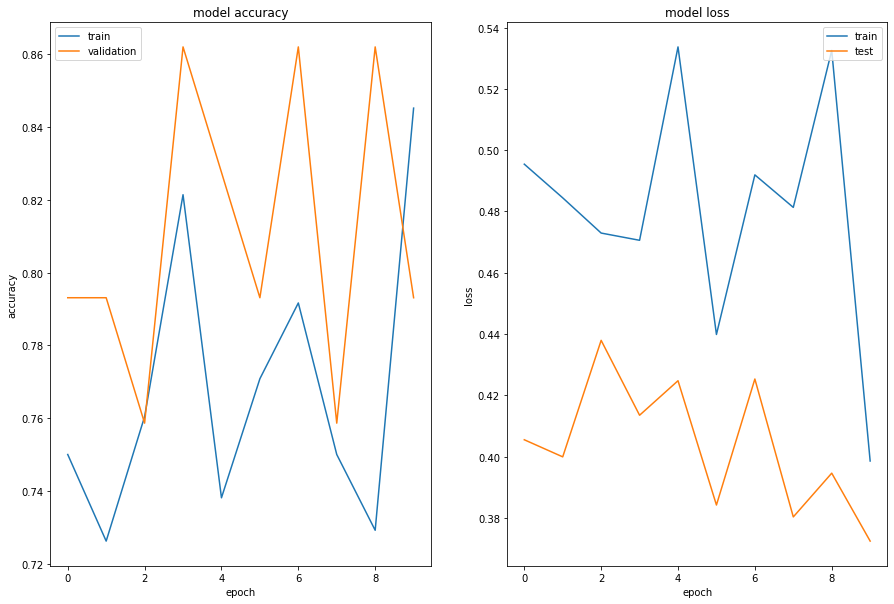

In [16]:
plot_acc_loss(H)

In [20]:

scores = modelvgg.evaluate(X_train, y_train, verbose=0)
print("%s: %.2f%%" % (modelvgg.metrics_names[1], scores[1]*100))


acc: 59.48%


In [21]:
scores = modelvgg.evaluate(X_test, y_test, verbose=0)
print("%s: %.2f%%" % (modelvgg.metrics_names[1], scores[1]*100))

acc: 62.07%
